In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

#import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Calculate the date 1 year ago from the last data point in the database
#session.query(Measurement.date).order_by(Measurement.date).first()
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#('2017-08-23')
lastDateStr = lastDate[0]

lastDate = datetime.strptime(lastDateStr,"%Y-%m-%d")
deltaOneYear = lastDate - dt.timedelta(days=365)
print(deltaOneYear)
deltaOneYearStr = deltaOneYear.strftime("%Y-%m-%d")
print(deltaOneYearStr)

2016-08-23 00:00:00
2016-08-23


In [16]:
query = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > deltaOneYearStr).\
    order_by(Measurement.date)
print(query)

SELECT measurement.prcp AS measurement_prcp, measurement.date AS measurement_date 
FROM measurement 
WHERE measurement.date > ? ORDER BY measurement.date


In [17]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > deltaOneYearStr).\
    order_by(Measurement.date).all()


In [35]:
#Get into a dict for the app, "unravel" the list of tuples returned, then zip into a dict
prcp = [t[0] for t in query]
dates = [t[1] for t in query]
prcp_dates = dict(zip(dates, prcp)) 
prcp_dates

{'2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': None,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-05': 0.18,
 '2016-09-06': 1.0,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 '2016-10-10': 0.0,
 

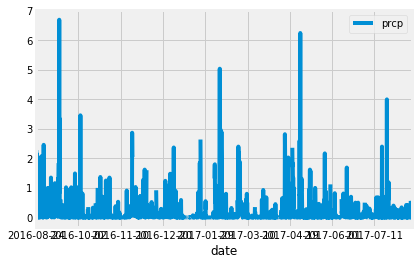

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the 
#date column
lastYearPrcp_df = pd.DataFrame(query)
lastYearPrcp_df.head()
lastYearPrcpSorted_df = lastYearPrcp_df.set_index('date',inplace=False)
lastYearPrcpSorted_df.head()
# Sort the dataframe by date
lastYearPrcpSorted_df = lastYearPrcpSorted_df.sort_values(by='date')
#lastYearPrcpSorted_df

# Use Pandas Plotting with Matplotlib to plot the data
lastYearPrcpSorted_df.plot(y='prcp')

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastYearPrcpSorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Design a query to show how many stations are available in this dataset?

In [21]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
session.query(func.count(Station.id)).all()

[(9)]

In [40]:
#CHANGE TO DESC
#lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationObsCounts = session.query(Measurement.station,func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
stationObsCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
#Create list for flask app
station_names = [t[0] for t in stationObsCounts]
station_names

['USC00518838',
 'USC00517948',
 'USC00511918',
 'USC00514830',
 'USC00516128',
 'USC00519523',
 'USC00513117',
 'USC00519397',
 'USC00519281']

In [41]:
#Grab first element station name, which is the most active
heavyStation = stationObsCounts[0][0]
heavyStation

'USC00519281'

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowTemp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == heavyStation).all()
#lowTemp
highTemp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == heavyStation).all()
#highTemp
avgTemp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == heavyStation).all()
tempSummaryTable = pd.DataFrame({'Station':heavyStation,
                                'Low Temp':lowTemp[0],
                                'High Temp':highTemp[0],
                                'Avg Temp':avgTemp[0]})
tempSummaryTable

,Station,Low Temp,High Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


[('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10-07', 76.0), ('2016-10

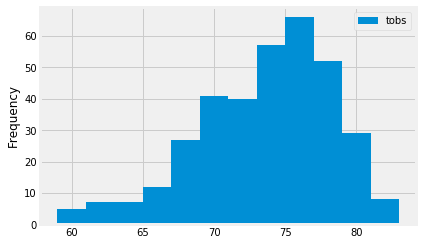

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastYearHeavyStation = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date > deltaOneYearStr).\
    filter(Measurement.station == heavyStation).\
    order_by(Measurement.date).all()
print(lastYearHeavyStation)
lastYearHeavyStation_df = pd.DataFrame(lastYearHeavyStation)
lastYearHeavyStationSorted_df = lastYearHeavyStation_df.set_index('date')
lastYearHeavyStationSorted_df = lastYearHeavyStationSorted_df.sort_values(by='date')
lastYearHeavyStationSorted_df.plot(y='tobs',kind='hist', bins=12)

In [45]:
#Create list for flask app
tObservations = [t[1] for t in lastYearHeavyStation]
tObservations

[77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,
 69.0,

In [46]:
#Test for flask app
start = "2016-08-23"
end = "2017-08-23"

lowTemp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.date > start).\
    filter(Measurement.date < end).\
    filter(Measurement.station == heavyStation).all()
lowTemp = [t[0] for t in lowTemp]
print(f"lowTemp is {lowTemp[0]}")

highTemp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.date > start).\
    filter(Measurement.date < end).\
    filter(Measurement.station == heavyStation).all()
highTemp = [t[0] for t in highTemp]
print(f"highTemp is {highTemp[0]}")

avgTemp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.date > start).\
    filter(Measurement.date < end).\
    filter(Measurement.station == heavyStation).all()
avgTemp = [t[0] for t in avgTemp]
print(f"avgTemp {avgTemp[0]}")

lowTemp is 59.0
highTemp is 83.0
avgTemp 73.0968660968661


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
